In [8]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import re
import unicodedata
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from tensorflow import keras
from tensorflow.keras.layers import Dense,Dropout, Input
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tensorflow.keras import regularizers
from transformers import TFDistilBertModel, DistilBertTokenizer, DistilBertConfig,  DistilBertForSequenceClassification, TFDistilBertForSequenceClassification

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/joostfranssen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
# Functions to preprocess the data
# stopwords, shortwords and special characters are removed 
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def clean_stopwords_shortwords(w):
    stopwords_list=stopwords.words('english')
    words = w.split() 
    clean_words = [word for word in words if (word not in stopwords_list) and len(word) > 2]
    return " ".join(clean_words) 

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r"([?.!,¿])", r" ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = clean_stopwords_shortwords(w)
    w = re.sub(r'@\w+', '',w)
    return w

In [10]:
TRAIN_FILE_PATH = '/Users/joostfranssen/Documents/Study/MSc_AI/Year_1/Semester_2A/Dl/Lab 2/train.csv'
TEST_FILE_PATH = '/Users/joostfranssen/Documents/Study/MSc_AI/Year_1/Semester_2A/Dl/Lab 2/test.csv'

train_data = pd.read_csv(TRAIN_FILE_PATH)
test_data = pd.read_csv(TEST_FILE_PATH)

train_data['Title'] = train_data['Title'].map(preprocess_sentence)
train_data['Description'] = train_data['Description'].map(preprocess_sentence)

X_train = train_data['Title'] + " " + train_data['Description']
y_train = train_data['Class Index'].apply(lambda x: x-1).values # Classes need to begin from 0

test_data['Title'] = test_data['Title'].map(preprocess_sentence)
test_data['Description'] = test_data['Description'].map(preprocess_sentence)

X_test = test_data['Title'] + " " + test_data['Description']
y_test = test_data['Class Index'].apply(lambda x: x-1).values # Classes need to begin from 0

len(X_train),len(y_train)

(120000, 120000)

In [11]:
max_len = 32
num_classes = 4

# Tokenize Data

In [12]:
# Load tokinezer 
dbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [13]:
# Tokenize training data
input_ids = []
attention_masks = []

for sent in X_train:
    dbert_inps=dbert_tokenizer.encode_plus(sent,add_special_tokens = True, max_length = max_len, padding = 'max_length', return_attention_mask = True, truncation=True)
    input_ids.append(dbert_inps['input_ids'])
    attention_masks.append(dbert_inps['attention_mask'])

train_input_ids = np.asarray(input_ids)
train_attention_masks = np.array(attention_masks)
y_train = np.array(y_train)

In [14]:
# Tokenize test data
test_input_ids = []
test_attention_masks = []

for sent in X_test:
    dbert_inps = dbert_tokenizer.encode_plus(sent, add_special_tokens = True, max_length = max_len, padding = 'max_length', return_attention_mask = True,truncation=True)
    test_input_ids.append(dbert_inps['input_ids'])
    test_attention_masks.append(dbert_inps['attention_mask'])

test_input_ids = np.asarray(test_input_ids)
test_attention_masks = np.array(test_attention_masks)
y_test = np.array(y_test)

# Optimize pretrained distilbert model

In [15]:
# Load pretrained distilbert model
dbert_model_pretrained = TFDistilBertModel.from_pretrained('distilbert-base-uncased') 

Metal device set to: Apple M1 Pro


2022-03-25 13:57:07.486632: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-25 13:57:07.487066: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-03-25 13:57:07.507658: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_projector', 'vocab_layer_norm', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task 

In [16]:
# function to create keras model with distilbert model, to train and generate output
def create_model_pretrained():
    inps = Input(shape = (max_len,), dtype='int64')
    masks = Input(shape = (max_len,), dtype='int64')
    dbert_layer = dbert_model_pretrained(inps, attention_mask=masks)[0][:,0,:]
    pred = Dense(num_classes, activation='softmax',kernel_regularizer=regularizers.l2(0.01)) (dbert_layer)   #(dropout)
    model = tf.keras.Model(inputs=[inps,masks], outputs=pred)
    print(model.summary())
    return model

In [17]:
pretrained_model = create_model_pretrained()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_1[0][0]',                
 BertModel)                     ast_hidden_state=(N               'input_2[0][0]']                
                                one, 32, 768),                                                    
                                 hidden_states=None                                           

In [71]:
train_inp, val_inp, train_label, val_label, train_mask, val_mask = train_test_split(train_input_ids, y_train, train_attention_masks, test_size=0.2)

print('Train shape {} Val input shape {}\nTrain label shape {} Val label shape {}\nTrain attention mask shape {} Val attention mask shape {}'.format(train_inp.shape,val_inp.shape,train_label.shape,val_label.shape,train_mask.shape,val_mask.shape))

log_dir='dbert_model_pretrained'
model_save_path='./dbert_model_pretrained.h5'

callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath = model_save_path, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True),keras.callbacks.TensorBoard(log_dir=log_dir)]

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)

pretrained_model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
history = pretrained_model.fit([train_inp,train_mask],train_label,batch_size=16, epochs=2, validation_data=([val_inp,val_mask],val_label),callbacks=callbacks)

Train shape (96000, 32) Val input shape (24000, 32)
Train label shape (96000,) Val label shape (24000,)
Train attention mask shape (96000, 32) Val attention mask shape (24000, 32)
Epoch 1/2


2022-03-25 15:08:11.244672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6000/6000 [==============================] - ETA: 0s - loss: 0.2074 - accuracy: 0.9397

2022-03-25 15:18:38.193460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6000/6000 [==============================] - 666s 110ms/step - loss: 0.2074 - accuracy: 0.9397 - val_loss: 0.1986 - val_accuracy: 0.9409
Epoch 2/2
6000/6000 [==============================] - 649s 108ms/step - loss: 0.1335 - accuracy: 0.9591 - val_loss: 0.1964 - val_accuracy: 0.9423


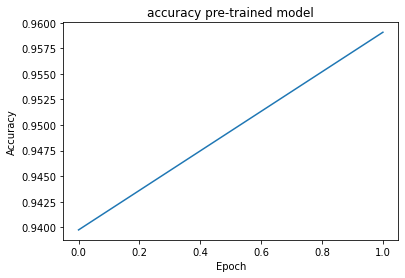

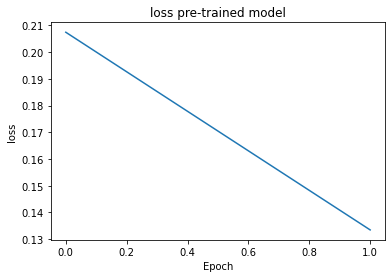

In [74]:
plt.plot(history.history['accuracy'])
plt.title('accuracy pre-trained model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

plt.plot(history.history['loss'])
plt.title('loss pre-trained model')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()

In [23]:
# load weights from saved optimized pretrained model
optimized_pretrained_model = create_model_pretrained()
optimized_pretrained_model.compile(loss=loss,optimizer=optimizer, metrics=[metric])
optimized_pretrained_model.load_weights(model_save_path)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_5[0][0]',                
 BertModel)                     ast_hidden_state=(N               'input_6[0][0]']                
                                one, 32, 768),                                                    
                                 hidden_states=None                                         

# Testing the pre trained model

In [26]:
preds = optimized_pretrained_model.predict([test_input_ids, test_attention_masks], batch_size=16)
pred_labels = np.argmax(preds, axis=1)
pred_labels


2022-03-25 14:23:55.787330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([2, 3, 3, ..., 1, 2, 2])

In [27]:
acc = accuracy_score(y_test, pred_labels)
acc

0.9228947368421052

In [30]:
target_names = ['world', 'sports', 'business', 'science']
print('Classification Report:')
print(classification_report(y_test, pred_labels, target_names=target_names)) 


Classification Report:
              precision    recall  f1-score   support

       world       0.96      0.90      0.93      1900
      sports       0.97      0.99      0.98      1900
    business       0.88      0.89      0.89      1900
     science       0.89      0.91      0.90      1900

    accuracy                           0.92      7600
   macro avg       0.92      0.92      0.92      7600
weighted avg       0.92      0.92      0.92      7600



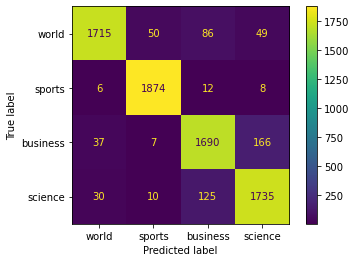

In [32]:
cm = confusion_matrix(y_test, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot()
plt.show()

# Training from scratch


In [40]:
config = DistilBertConfig()
dbert_model_untrained = TFDistilBertModel(config)

In [41]:
# function to create keras model with distilbert model, to train and generate output
def create_model_untrained():
    inps = Input(shape = (max_len,), dtype='int64')
    masks = Input(shape = (max_len,), dtype='int64')
    dbert_layer = dbert_model_untrained(inps, attention_mask=masks)[0][:,0,:]
    pred = Dense(num_classes, activation='softmax',kernel_regularizer=regularizers.l2(0.01)) (dbert_layer)   #(dropout)
    model = tf.keras.Model(inputs=[inps,masks], outputs=pred)
    print(model.summary())
    return model

In [42]:
scratch_model = create_model_untrained()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 tf_distil_bert_model_1 (TFDist  TFBaseModelOutput(l  66362880   ['input_7[0][0]',                
 ilBertModel)                   ast_hidden_state=(N               'input_8[0][0]']                
                                one, 32, 768),                                                    
                                 hidden_states=None                                         

In [43]:
# zullen we het opnieuw splitsen of gebruiken we dezelfde train en validation van de pretrained
train_inp, val_inp, train_label, val_label, train_mask, val_mask = train_test_split(train_input_ids, y_train, train_attention_masks, test_size=0.2)

print('Train inp shape {} Val input shape {}\nTrain label shape {} Val label shape {}\nTrain attention mask shape {} Val attention mask shape {}'.format(train_inp.shape,val_inp.shape,train_label.shape,val_label.shape,train_mask.shape,val_mask.shape))

log_dir='dbert_model_scratch'
model_save_path='./dbert_model_scratch.h5'

callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath = model_save_path, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True),keras.callbacks.TensorBoard(log_dir=log_dir)]

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)

scratch_model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
scratch_model.fit([train_inp,train_mask],train_label,batch_size=16,epochs=1, validation_data=([val_inp,val_mask],val_label),callbacks=callbacks)

Train inp shape (96000, 32) Val input shape (24000, 32)
Train label shape (96000,) Val label shape (24000,)
Train attention mask shape (96000, 32) Val attention mask shape (24000, 32)


2022-03-25 14:29:08.168321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6000/6000 [==============================] - ETA: 0s - loss: 0.4520 - accuracy: 0.8677

2022-03-25 14:39:31.182238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6000/6000 [==============================] - 661s 109ms/step - loss: 0.4520 - accuracy: 0.8677 - val_loss: 0.3419 - val_accuracy: 0.9018


In [ ]:
plt.plot(history.history['accuracy'])
plt.title('Loss scratch model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

plt.plot(history.history['loss'])
plt.title('Categorical Accuracy scratch model')
plt.ylabel('Categorical Accuracy')
plt.xlabel('Epoch')
plt.show()

In [49]:
# load weights from saved trained model from scratch
scratch_trained_model = create_model_untrained()
scratch_trained_model.compile(loss=loss,optimizer=optimizer, metrics=[metric])
scratch_trained_model.load_weights(model_save_path)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 32)]         0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 32)]         0           []                               
                                                                                                  
 tf_distil_bert_model_1 (TFDist  TFBaseModelOutput(l  66362880   ['input_11[0][0]',               
 ilBertModel)                   ast_hidden_state=(N               'input_12[0][0]']               
                                one, 32, 768),                                                    
                                 hidden_states=None                                         

# Testing the scratch model

In [54]:
preds_scratch = scratch_trained_model.predict([test_input_ids, test_attention_masks], batch_size=16)
pred_labels_scratch = np.argmax(preds_scratch, axis=1)
pred_labels_scratch

array([2, 3, 3, ..., 1, 2, 3])

In [55]:
acc_scratch = accuracy_score(y_test, pred_labels_scratch)
acc_scratch

0.9027631578947368

In [56]:
target_names = ['world', 'sports', 'business', 'science']
print('Classification Report:')
print(classification_report(y_test, pred_labels_scratch, target_names=target_names)) 

Classification Report:
              precision    recall  f1-score   support

       world       0.94      0.88      0.91      1900
      sports       0.96      0.98      0.97      1900
    business       0.90      0.81      0.85      1900
     science       0.82      0.94      0.88      1900

    accuracy                           0.90      7600
   macro avg       0.91      0.90      0.90      7600
weighted avg       0.91      0.90      0.90      7600



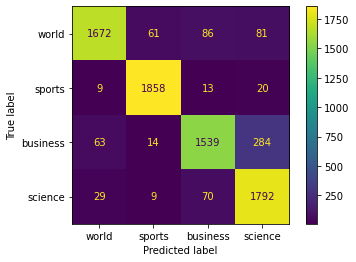

In [57]:
cm_scratch = confusion_matrix(y_test, pred_labels_scratch)
disp_scratch = ConfusionMatrixDisplay(confusion_matrix=cm_scratch, display_labels=target_names)
disp_scratch.plot()
plt.show()